# Bond Mechanics 101
<p style="color:darkblue; "><b>A TurningBull Notebook</b>


The objective this month is to understand the basic mechanics of interest rates, yield curves, and how they relate to bond valuation.  Two important numerical routines we'll introduce are the **cubic spline** method for interpolating yield curves, and the **bootstrapping** method for constructing yield curves from a set of bonds.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from urllib.request import urlopen
import json
from scipy.interpolate import CubicSpline

For this notebook we are using a dataset of historical treasury rates between 1 Jan, 2023 - 30 Apr, 2025, downloaded from **FMP**.  This data is also freely available from the **Federal Reserve** and other sources.  It has been saved in *json* format in the *dat/may2025* folder.

In [2]:
def read_fmp():
    with open("../.fmp_api.key", "r") as f:
        api_key = f.read().strip()

    url = f"https://financialmodelingprep.com/stable/treasury-rates?from=2023-01-01&&apikey={api_key}"
    response = urlopen(url)
    return pd.DataFrame(json.loads(response.read().decode("utf-8")))

def save_json(data, filename):
    res = data.to_json(orient="records")
    with open(filename, "w") as f:
        json.dumps(f.write(res))

def load_json(filename):
    with open(filename, "rb") as f:
        data = json.loads(f.read())
    return pd.DataFrame(data)
#par_rates = read_fmp()
#save_json(par_rates, "../dat/may2025/par_rates.json")
par_rates = load_json("../dat/may2025/par_rates.json")
print(par_rates.head())

         date  month1  month2  month3  month6  year1  year2  year3  year5  \
0  2025-05-16    4.37    4.34    4.37    4.30   4.13   3.98   3.95   4.06   
1  2025-05-15    4.37    4.35    4.38    4.29   4.10   3.96   3.95   4.07   
2  2025-05-14    4.39    4.36    4.41    4.30   4.14   4.05   4.05   4.17   
3  2025-05-13    4.39    4.35    4.41    4.29   4.11   4.02   4.00   4.12   
4  2025-05-12    4.38    4.36    4.42    4.29   4.11   3.98   3.97   4.09   

   year7  year10  year20  year30  
0   4.24    4.43    4.92    4.89  
1   4.25    4.45    4.93    4.91  
2   4.35    4.53    5.00    4.97  
3   4.30    4.49    4.97    4.94  
4   4.27    4.45    4.92    4.89  


These interest rates represent the **par yields** on U.S. Treasury securities, which are the yields on bonds that are issued at face value and pay interest semi-annually.  The par yield is the coupon rate that makes the present value of the bond's cash flows equal to its face value.

In [24]:
## Tenors are the official maturity dates published for US Treasury securities.  They are also the known as key rates.
## The tenors are: 1 month, 2 month, 3 month, 6 month, 1 year, 2 year, 3 year, 5 year, 7 year, 10 year, 20 year, and 30 year.
tenors = [(t, float(t.replace("month", "").replace("year","")) / \
           (12 if "month" in t else 1)) for t in par_rates.columns[1:]]

## xt is a complete set of maturities for constructing the yield curve.  Starting at the 6 month tenor they are evenly spaced out to 30 years.
xt = np.concatenate((np.array([t[1] for t in tenors[:4]]), np.arange(1, 30.5, 0.5)))

There are several approaches to interpolation.  In our case, we will use the **cubic spline** method, which is a piecewise polynomial interpolation technique that ensures smoothness and continuity of the yield curve.  This method is particularly useful for constructing yield curves from discrete data points, such as the par yields of treasury securities.

In [4]:
def interpolate_curve(tenors, rates, xt):
    spline = CubicSpline(
        [t[1] for t in tenors], rates, bc_type="natural"
    )
    yt = spline(xt)
    return (pd.DataFrame(
            {
                "xt": xt,
                "par_rate": yt,
            }
        ).assign(key_rate = lambda df_: [1 if df_.xt.iloc[i] in [t[1] for t in tenors] else 0 for i in range(df_.shape[0])])
    )

interpolated_curve = interpolate_curve(tenors, par_rates.iloc[0, 1:], xt)

In [27]:
par_rates = \
(
    par_rates[par_rates.date.isin(["2025-04-30", "2025-03-31", "2024-12-31", "2023-12-29"])]
    .set_index("date")
    .apply(lambda x: interpolate_curve(tenors, x, xt).par_rate, axis=1)
    .T
    .assign(xt = xt.round(3),
            tenor = lambda df_: (df_.set_index("xt")
                                 .join(pd.DataFrame(tenors, columns = ["tenor", "years"])
                                       .assign(xt = lambda x: x.years.round(3))
                                       .set_index("xt"), how = "left")
                                 .reset_index()
                                 .tenor))
)

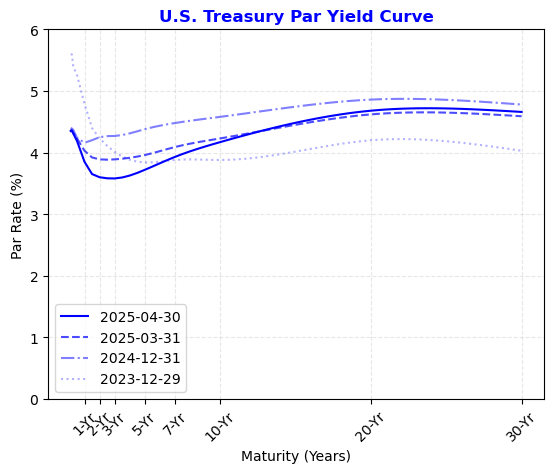

In [28]:
## plot the par curve for most recent data, prior month, beginning of year and last year
def plot_par_rates(data):
    dates = data.columns[:4]
    label_i = data.where(lambda df_: df_.tenor.notna() & df_.tenor.str.contains("year")).dropna().index
    x_labels = [f"{i}-Yr" for i in data.tenor.loc[label_i].str.replace("year","")]
    
    fig, ax = plt.subplots()
    ax.plot(data.xt, data.iloc[:, 0], label = dates[0], color='blue')
    ax.plot(data.xt, data.iloc[:, 1], label = dates[1], color='blue', alpha = 0.7, linestyle='--')
    ax.plot(data.xt, data.iloc[:, 2], label = dates[2], color='blue', alpha = 0.5, linestyle='-.')
    ax.plot(data.xt, data.iloc[:, 3], label = dates[3], color='blue', alpha = 0.3, linestyle=':')
    
    ax.set_title("U.S. Treasury Par Yield Curve", fontweight = "bold", color = "blue")
    ax.set_ylabel("Par Rate (%)")
    ax.set_xlabel("Maturity (Years)")
    ax.set_ylim(0, 6)
   
    ax.set_xticks(data.xt.loc[label_i])
    ax.set_xticklabels(x_labels, rotation=45)
    ax.grid(alpha=0.3, linestyle='--')
    ax.legend()
    plt.show()

plot_par_rates(par_rates)

In [29]:
def bootstrapSpotRates(par_rates):
    """
    Compute the spot rate for a given maturity i using the par rates.
    """
    spot_rates = []
    subyear_counter = 0
    for i in range(par_rates.shape[0]):
        if par_rates.iloc[i, 0] < 1:
            spot_rates.append(par_rates.iloc[i, 1])
            subyear_counter += 1
        else:
            fv = 100
            c = par_rates.iloc[i, 1] / 2.
            xt = np.arange(0.5, par_rates.iloc[i, 0] + 0.5, 0.5)
            rt = spot_rates[subyear_counter - 1:]
            df = np.sum([1. / (1 + rt[j] / 200.) ** (2 * xt[j]) for j in range(len(rt))])
            spot_rates.append((((fv + c) / (fv - c * df)) ** (1. / len(xt))- 1) * 200)
    return pd.Series(spot_rates, index=par_rates.index)
 
#interpolated_curve["spot_rate"] = bootstrapSpotRates(interpolated_curve)

In [30]:
spot_rates = \
(
    pd.DataFrame([bootstrapSpotRates(par_rates.iloc[:, [4, i]]) for i in range(4)])
    .T
    .set_axis(par_rates.columns[:4].to_list(), axis=1)
    .assign(xt=par_rates.xt)
    .where(lambda df_: df_.xt.ge(0.5))
    .dropna(how="all")
)

In [9]:
def compute_forward_rates(spot_rates):
    """
    Compute the forward rate for a given maturity i using the spot rates.
    spot_rates is a pd.Series for a given set of spot rates indexed by xt. 
    """
    forward_rates = []
    for i, ti in enumerate(spot_rates.index):
        if i == 0:
            forward_rates.append(spot_rates.iloc[i])
        else:
            forward_rate = 2 * ((1 + spot_rates.iloc[i] / 200) ** (2 * ti) / (1 + spot_rates.iloc[i - 1] / 200) ** (2 * ti - 1) - 1)
            forward_rates.append(forward_rate * 100)
    return pd.Series(forward_rates, index=spot_rates.index)

In [10]:
forward_rates = compute_forward_rates(pd.Series(spot_rates.iloc[:, 0].values, index=spot_rates.xt))

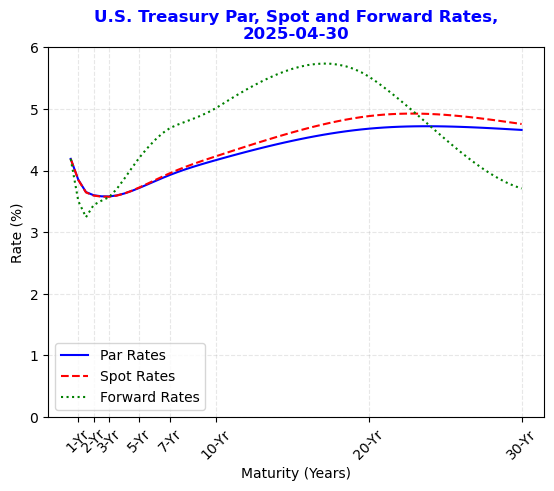

In [31]:
## plot the par curve with corresponding spot rates for most recent month-end.
def plot_par_spot_forward_rates(data, date):
    
    label_i = data.where(lambda df_: df_.tenor.notna() & df_.tenor.str.contains("year")).dropna().index
    x_labels = [f"{i}-Yr" for i in data.tenor.loc[label_i].str.replace("year","")]
    
    fig, ax = plt.subplots()
    ax.plot(data.xt, data.iloc[:, 0], label = "Par Rates", color='blue')
    ax.plot(data.xt, data.iloc[:, 1], label = "Spot Rates", color='red', linestyle='--')
    ax.plot(data.xt, data.iloc[:, 2], label = "Forward Rates", color='green', linestyle=':')

    ax.set_title(f"U.S. Treasury Par, Spot and Forward Rates,\n{date}", fontweight = "bold", color = "blue")
    ax.set_ylabel("Rate (%)")
    ax.set_xlabel("Maturity (Years)")
    ax.set_ylim(0, 6)
   
    ax.set_xticks(data.xt.loc[label_i])
    ax.set_xticklabels(x_labels, rotation=45)
    ax.grid(alpha=0.3, linestyle='--')
    ax.legend()
    plt.show()

plot_par_spot_forward_rates(
    pd.concat(
        [par_rates.iloc[3:, 0].rename("Par Rates"), 
         spot_rates.iloc[:, 0].rename("Spot Rates"), 
         pd.Series(forward_rates.values, index = spot_rates.index).rename("Forward Rates"),
         par_rates.iloc[3:, -2:]], axis=1
    ), "2025-04-30"
)

In [12]:
def spot_rates_to_discount_factors(spot_rates):
    """
    Convert spot rates to discount factors.
    """
    return (1 + spot_rates.values / 200) ** (-2 * spot_rates.index.values)

def forward_rates_to_discount_factors(forward_rates):
    """
    Convert forward rates to discount factors.
    """
    return 1 / (1 + forward_rates.values / 200).cumprod()

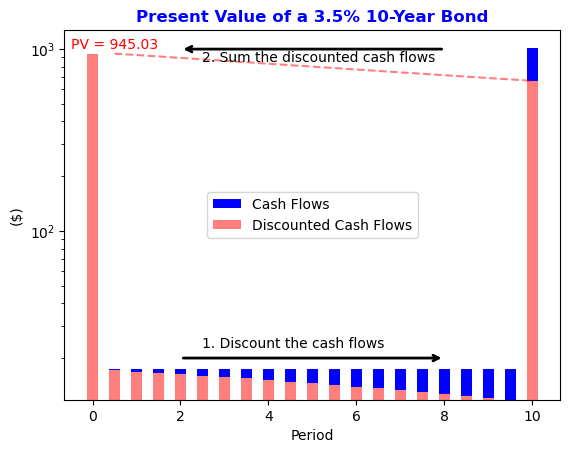

In [23]:
def plot_bond_cf(coupon_rate, n_maturity, discount_factors, face_value = 100):
    """
    Plot the cash flows of a bond with a given coupon rate, maturity, and discount factors.
    """
    n = int(n_maturity * 2)
    coupon = coupon_rate / 200 * face_value 
    cash_flows = np.array([coupon] * (n - 1) + [coupon + face_value])
    xt = np.arange(0.5, n_maturity + 0.5, 0.5)
    pv = np.sum(cash_flows * discount_factors[:n])
    discount_cf_sum = np.cumsum((cash_flows * discount_factors[:n])[::-1])[::-1]

    _, ax = plt.subplots()
    bar1 = ax.bar(xt, cash_flows * discount_factors[:n], label="Discounted Cash Flows", color='red', width=0.25, alpha=0.5)
    bar2 = ax.bar(xt, cash_flows * (1 - discount_factors[:n]), bottom=cash_flows * discount_factors[:n], width=0.25, label="Cash Flows", color='blue')
    # Reverse the series for present value
    ax.plot(xt, discount_cf_sum, color='red', linestyle='--', alpha=0.5)
    ax.bar(0, pv, width=0.25, color='red', alpha=0.5)

    # Add an arrow pointing left near the top
    ax.annotate("", xytext = (2, 1000), xy = (8, 1000), arrowprops=dict(facecolor='black', arrowstyle='<-', lw=2))
    ax.text(2.5, 975, "2. Sum the discounted cash flows", fontsize=10, color='black', ha='left', va='top')
    # Add an arrow pointing right at the bottom
    ax.annotate("", xytext = (2, 20), xy = (8, 20), arrowprops=dict(facecolor='black', arrowstyle='->', lw=2))
    ax.text(2.5, 22, "1. Discount the cash flows", fontsize=10, color='black', ha='left', va='bottom')
    ax.text(-0.5, pv + 20, f"PV = {pv:.2f}", fontsize=10, color='red', ha='left', va='bottom')
    
    ax.set_title(f"Present Value of a {coupon_rate}% {n_maturity}-Year Bond", fontweight = "bold", color = "blue")
    ax.set_xlabel("Period")
    ax.set_ylabel("($)")
    # Only show Cash Flows and Discounted Cash Flows in legend
    ax.legend([bar2, bar1], ["Cash Flows", "Discounted Cash Flows"])
    ax.set_yscale('log')
    plt.show()

plot_bond_cf(3.5, 10, spot_rates_to_discount_factors(pd.Series(spot_rates.iloc[:, 0].values, index=spot_rates.xt)), face_value = 1000)

In [18]:
def pv_bond(coupon_rate, n_maturity, spot_rates, face_value=100):
    """
    Compute the present value of a bond given its coupon rate, maturity, and face value.
    """
    n = int(n_maturity * 2)
    coupon = coupon_rate / 200 * face_value
    cash_flows = np.array([coupon] * (n - 1) + [face_value + coupon])
    discount_factors = (1 + spot_rates.iloc[:n, 1] / 200) ** (-2 * spot_rates.iloc[:n, 0])
    pv = np.sum(cash_flows * discount_factors)
    return pv

pv_bond(4.32, 10, spot_rates.loc[:, ["xt", "2025-04-30"]], 1000)

np.float64(1012.3075653365418)

In [19]:
def pv_bond_fr(coupon_rate, n_maturity, forward_rates, face_value = 100):
    '''
    Compute the present value of a bond given its coupon rate, maturity and face value
    using forward rates for discount factors.
    '''
    n = int(n_maturity * 2)
    coupon = coupon_rate / 200 * face_value
    cash_flows = np.array([coupon] * (n - 1) + [face_value + coupon])
    discount_factors = 1 / (1 + forward_rates.iloc[:n] / 200).cumprod()
    pv = np.sum(cash_flows * discount_factors)
    return pv

pv_bond_fr(4.32, 10, forward_rates, 1000)

np.float64(1012.307565336542)

In [20]:
## confirm spot rates value par bonds at par
par_bonds = \
(
    key_rates.iloc[3:, [4, 0]]
    .apply(lambda x: pv_bond(x.iloc[1], x.iloc[0], spot_rates.iloc[:, [4, 0]], 1000), axis=1)
)
assert np.all(np.isclose(par_bonds, 1000, atol=0.01)), "Bonds do not price at par"

In [21]:
def pv_bond_ytm(coupon_rate, ytm, n_maturity, face_value=100):
    """
    Compute the present value of a bond given its coupon rate, yield to maturity, and maturity.
    """
    coupon = coupon_rate / 200 * face_value
    cash_flows = np.array([coupon] * (n_maturity * 2 - 1) + [face_value + coupon])
    discount_factors = (1 + ytm / 200.) ** (-2 * np.arange(0.5, n_maturity + 0.5, 0.5))
    pv = np.sum(cash_flows * discount_factors)
    return pv

def analytic_derivative(bond_price, coupon_rate, ytm, n_maturity, face_value=100):
    """
    Compute the derivative of the present value of a bond with respect to its coupon rate.
    """
    coupon = coupon_rate / 200. * face_value
    cash_flows = np.array([coupon * i for i in np.arange(0.5, n_maturity, 0.5)] + [n_maturity * (face_value + coupon)])
    discount_factors = (1 + ytm / 200.) ** (-(2 * np.arange(0.5, n_maturity + 0.5, 0.5) + 1))
    pv = np.sum(cash_flows * discount_factors)
    
    return pv

def forward_difference(bond_price, coupon_rate, ytm, n_maturity, face_value=100, delta=1e-5):
    """
    Compute the derivative of the present value of a bond with respect to its coupon rate using finite differences.
    """
    f1 = bond_price - pv_bond_ytm(coupon_rate, ytm + delta * 100, n_maturity, face_value)
    f2 = bond_price - pv_bond_ytm(coupon_rate, ytm, n_maturity, face_value)
    return (f1 - f2) / delta

def backward_difference(bond_price, coupon_rate, ytm, n_maturity, face_value=100, delta=1e-5):
    """
    Compute the derivative of the present value of a bond with respect to its coupon rate using finite differences.
    """
    f1 = bond_price - pv_bond_ytm(coupon_rate, ytm, n_maturity, face_value)
    f2 = bond_price - pv_bond_ytm(coupon_rate, ytm - delta * 100, n_maturity, face_value)
    return (f1 - f2) / delta

def central_difference(bond_price, coupon_rate, ytm, n_maturity, face_value=100, delta=1e-5):
    """
    Compute the derivative of the present value of a bond with respect to its coupon rate using finite differences.
    """
    f1 = bond_price - pv_bond_ytm(coupon_rate, ytm + delta * 100, n_maturity, face_value)
    f2 = bond_price - pv_bond_ytm(coupon_rate, ytm - delta * 100, n_maturity, face_value)
    return (f1 - f2) / (2 * delta)


def yield_to_maturity(bond_price, coupon_rate, n_maturity, face_value=100, derivative_func = analytic_derivative, tolerance=1e-6, max_iterations=10000, *args, **kwargs):
    """
    Use the Newton-Raphson method to find the coupon rate that makes the present value of a bond equal to a target value.
    """
    ytm = coupon_rate
    ytm_old = 0
    for i in range(max_iterations):
        if abs(ytm - ytm_old) < tolerance:
            return (ytm, i)
        ytm_old = ytm
        pv = pv_bond_ytm(coupon_rate, ytm, n_maturity, face_value)
        ytm = ytm_old - (bond_price - pv) / derivative_func(bond_price, coupon_rate, ytm, n_maturity, face_value, *args, **kwargs)
    raise ValueError(f"Newton-Raphson method did not converge; {ytm} vs. {ytm_old} after {i} iterations.")

target_pv = 980
yield_to_maturity(target_pv, 4.32, 10, 1000), yield_to_maturity(1000, 4.32, 10, 1000)


((np.float64(4.571325175060531), 782), (np.float64(4.32), 1))

In [22]:
face_value = 1000
coupon_rate = key_rates[key_rates.xt.eq(10)].iloc[0, 0]
n_maturity = 10
market_prices = np.arange(800, 1200, 10)
max_iterations = 10000

analytic_ytm = np.array([yield_to_maturity(mv, coupon_rate, n_maturity, face_value) for mv in market_prices])
forward_diff_ytm = np.array([yield_to_maturity(mv, coupon_rate, n_maturity, face_value, forward_difference, max_iterations=max_iterations) for mv in market_prices])
backward_diff_ytm = np.array([yield_to_maturity(mv, coupon_rate, n_maturity, face_value, backward_difference, max_iterations=max_iterations) for mv in market_prices])
central_diff_ytm = np.array([yield_to_maturity(mv, coupon_rate, n_maturity, face_value, central_difference, max_iterations=max_iterations) for mv in market_prices])

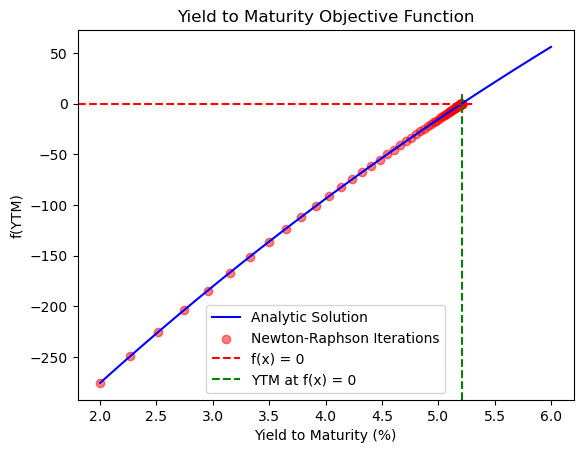

In [23]:
# plot the objective function for the YTM analytic solution
def plot_ytm(market_price, coupon_rate, n_maturity, face_value):
    
    fig, ax = plt.subplots()
    fx = lambda x: market_price - pv_bond_ytm(coupon_rate, x, n_maturity, face_value)
    x = np.linspace(2, 6, 1000)
    y = [fx(i) for i in x]
    ax.plot(x, y, label = "Analytic Solution", color='blue')
    
    ## for plotting the iterations
    iters = []
    counter = 0
    ytm = 2.0
    ytm_old = 0
    for i in range(10000):
        if abs(ytm - ytm_old) < 1e-6:
            break
        ytm_old = ytm
        pv = pv_bond_ytm(coupon_rate, ytm, n_maturity, face_value)
        if counter % 10 == 0:
            iters.append((ytm, market_price - pv))
        ytm = ytm_old - (market_price - pv) / analytic_derivative(market_price, coupon_rate, ytm, n_maturity, face_value)
        counter += 1
    
    ax.scatter([i[0] for i in iters], [i[1] for i in iters], color='red', label='Newton-Raphson Iterations', alpha=0.5)

    y_zero = 0
    x_zero = x[np.argmin(np.abs(y))]
    ax.axhline(y_zero, color='red', linestyle='--', label='f(x) = 0', xmax=(x_zero - x[0]) / (x[-1] - x[0]))
    ax.axvline(x_zero, color='green', linestyle='--', label='YTM at f(x) = 0', ymax=(y_zero - min(y)) / (max(y) - min(y)))

    ax.set_title("Yield to Maturity Objective Function")
    ax.set_xlabel("Yield to Maturity (%)")
    ax.set_ylabel("f(YTM)")
    ax.legend()
    plt.show()

plot_ytm(920, coupon_rate, n_maturity, face_value)


In [24]:
def rmse(a, b):
    """
    Compute the root mean square error between two arrays.
    """
    return np.sqrt(np.mean((a - b) ** 2))

[f"{rmse(analytic_ytm[:,0], i[:,0]):0.2e}" for i in [forward_diff_ytm, backward_diff_ytm, central_diff_ytm]]

['2.62e-07', '3.98e-07', '1.51e-12']

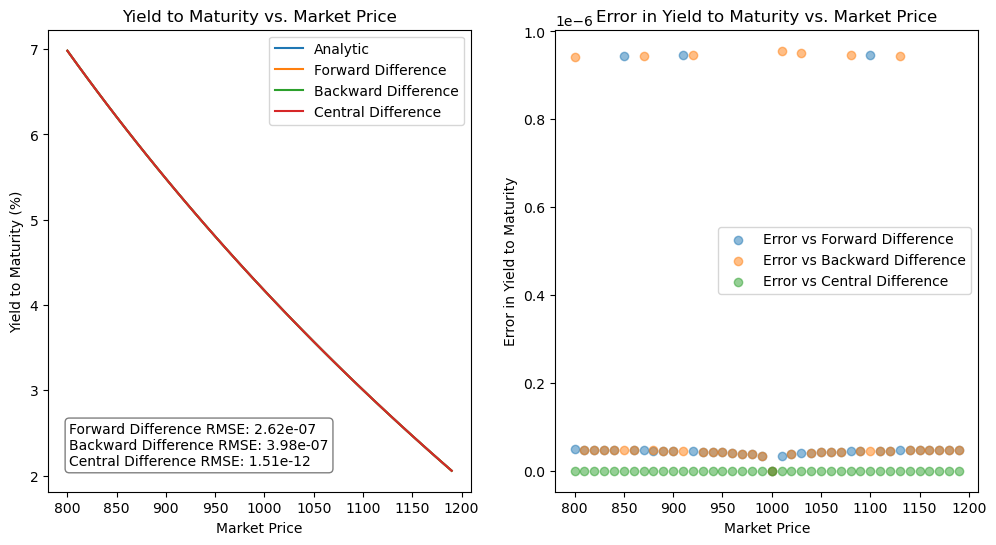

In [25]:
## plot YTM vs. market price
def plot_ytm_vs_price(market_prices, ytms, ytm_labels):
    """
    Plot the yield to maturity against market prices.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    for i, ytm in enumerate(ytms):
        ax1.plot(market_prices, ytm[:, 0], label=ytm_labels[i])
    
    ax1.set_title("Yield to Maturity vs. Market Price")
    ax1.set_xlabel("Market Price")
    ax1.set_ylabel("Yield to Maturity (%)")
    ax1.legend()
    
    # Exclude the analytic method for error calculation
    for i, ytm in enumerate(ytms[1:]):  # Exclude the analytic method for error calculation
        error = np.abs(ytm[:, 0] - ytms[0][:, 0])  # Absolute error compared to analytic method
        ax2.scatter(market_prices, error, label=f"Error vs {ytm_labels[i+1]}", alpha=0.5)
    
    rmse_text = [f"{rmse(analytic_ytm[:,0], i[:,0]):0.2e}" for i in [forward_diff_ytm, backward_diff_ytm, central_diff_ytm]]
    text_str = "\n".join([f"{ytm_labels[i+1]} RMSE: {rmse_text[i]}" for i in range(len(rmse_text))])
    ax1.text(0.05, 0.05, text_str, transform=ax1.transAxes, fontsize=10, verticalalignment='bottom', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
    ax2.set_title("Error in Yield to Maturity vs. Market Price")
    ax2.set_xlabel("Market Price")
    ax2.set_ylabel("Error in Yield to Maturity")
    ax2.legend()
    
    plt.show()

ytm_labels = ["Analytic", "Forward Difference", "Backward Difference", "Central Difference"]
ytms = [analytic_ytm, forward_diff_ytm, backward_diff_ytm, central_diff_ytm]
plot_ytm_vs_price(market_prices, ytms, ytm_labels)